### Labeling

#### Exercise 1

E-mini S&P500 future 시계열을 고려할 때 1분 수익률의 두 표준 편차로 설정된 고정 기간 방법을 사용해 1분 시간 바로 레이블을 계산하라. (여기서는 1분 바로 구성할 수 없기 때문에 1일 바로 구성하도록 한다)

In [132]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [133]:
start_date = '2000-01-01'
end_date = '2024-03-12'
ticker = 'ES=F'

data = yf.download(ticker, start = start_date, end = end_date)

[*********************100%%**********************]  1 of 1 completed


In [134]:
ret = np.log(data['Close'] / data['Close'].shift(1)).fillna(0)

**1.1**

label의 전체 분포를 계산하라

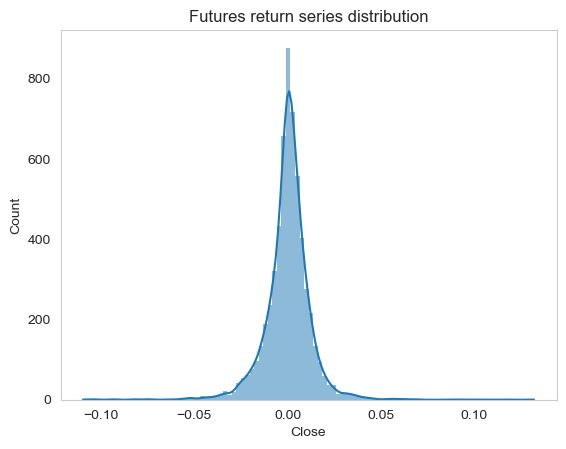

In [12]:
sns.histplot(
    ret,
    bins = 100,
    edgecolor = 'none',
    kde = True
)
plt.grid(False)
plt.title('Futures return series distribution')
plt.show()

**1.2**

트레이딩 세션의 각 시간별로 일 전체에 걸친 레이블 분포를 계산하라.

- 여기선 각 시간별로 구분할 수가 없기 때문에, 요일별로 분포를 계산해본다.

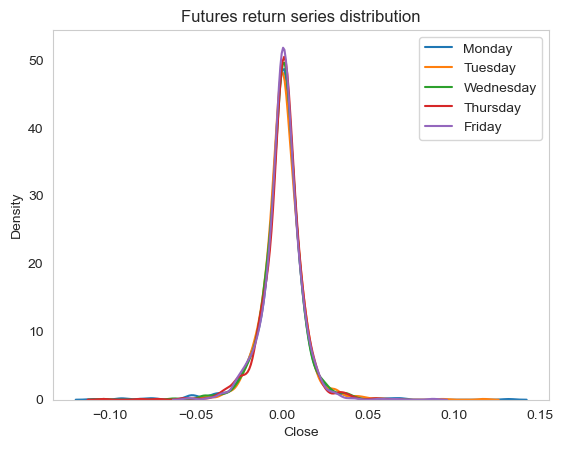

In [22]:
sns.kdeplot(
    ret[ret.index.dayofweek == 0],
    label = 'Monday'
)
sns.kdeplot(
    ret[ret.index.dayofweek == 1],
    label = 'Tuesday'
)
sns.kdeplot(
    ret[ret.index.dayofweek == 2],
    label = 'Wednesday'
)
sns.kdeplot(
    ret[ret.index.dayofweek == 3],
    label = 'Thursday'
)
sns.kdeplot(
    ret[ret.index.dayofweek == 4],
    label = 'Friday'
)
plt.legend()
plt.grid(False)
plt.title('Futures return series distribution')
plt.show()

In [34]:
from FinancialMachineLearning.features.volatility import daily_volatility
vol = daily_volatility(data.Close, lookback = 21)

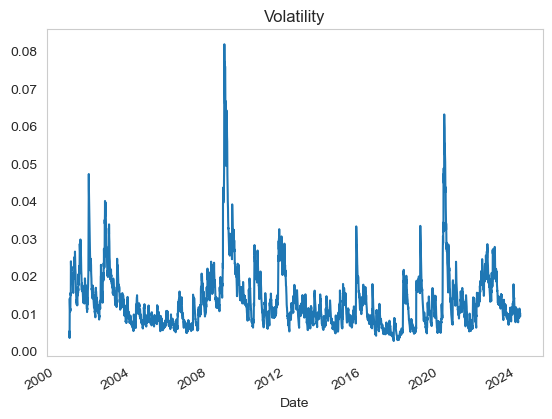

In [37]:
vol.plot(
    grid = False,
    title = 'Volatility'
)
plt.show()

In [38]:
from FinancialMachineLearning.filter.filter import cusum_filter

cusum_events = cusum_filter(data.Close, threshold = vol.mean())

In [65]:
from FinancialMachineLearning.labeling.labeling import *

vertical_barrier = add_vertical_barrier(cusum_events, data['Close'], num_days = 7)
vertical_barrier

2000-09-19   2000-09-26
2000-09-20   2000-09-27
2000-09-22   2000-09-29
2000-09-25   2000-10-02
2000-09-26   2000-10-03
                ...    
2024-02-27   2024-03-05
2024-02-28   2024-03-06
2024-02-29   2024-03-07
2024-03-01   2024-03-08
2024-03-04   2024-03-11
Name: Date, Length: 5857, dtype: datetime64[ns]

In [79]:
triple_barrier_events = get_events(
    close = data['Close'],
    t_events = cusum_events[1:],
    pt_sl = [1, 1],
    target = vol,
    min_ret = ret.mean(),
    num_threads = 1,
    vertical_barrier_times = vertical_barrier,
    side_prediction = None
)
triple_barrier_events

,t1,trgt,pt,sl
2000-09-22,2000-09-25,0.003798,1,1
2000-09-25,2000-09-26,0.003469,1,1
2000-09-26,2000-09-28,0.007563,1,1
2000-09-27,2000-09-28,0.006773,1,1
2000-09-28,2000-09-29,0.013980,1,1
...,...,...,...,...
2024-03-05,2024-03-07,0.010008,1,1
2024-03-06,2024-03-07,0.009764,1,1
2024-03-07,NaT,0.010148,1,1
2024-03-08,NaT,0.009680,1,1


In [80]:
labels = meta_labeling(triple_barrier_events, data['Close'])
labels

,ret,trgt,bin
2000-09-22,-0.005107,0.003798,-1
2000-09-25,-0.012320,0.003469,-1
2000-09-26,0.022869,0.007563,1
2000-09-27,0.020218,0.006773,1
2000-09-28,-0.014905,0.013980,-1
...,...,...,...
2024-02-29,0.011364,0.009754,1
2024-03-01,-0.011708,0.009756,-1
2024-03-04,-0.010217,0.009428,-1
2024-03-05,0.014944,0.010008,1


In [81]:
labels['bin'].value_counts()

 1    2375
-1    1981
 0    1501
Name: bin, dtype: int64

#### Exercise 2

연습 1을 반복한다. 이때 표준화된 수익률에 레이블을 붙인다. 여기서는 표준화는 1시간의 lookback에서 얻은 평균과 분산 추정치에 기초한다. 이때 연습 1과 다른 결론에 도달하는가?

- 여기서는 1시간의 lookback 대신에 한 달 간의 평균과 분산 추정치를 사용하도록 한다

In [69]:
std_ret = (ret - ret.rolling(window = 21).mean()) / ret.rolling(window = 21).std()

In [70]:
std_ret.dropna(inplace = True)

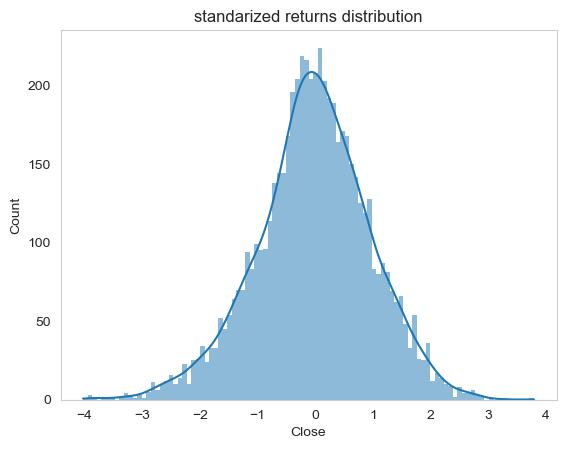

In [31]:
sns.histplot(
    std_ret,
    edgecolor = 'none',
    kde = True,
    bins = 100
)
plt.grid(False)
plt.title('standarized returns distribution')
plt.show()

정규분포에 더 비슷한 모양을 갖게 된다

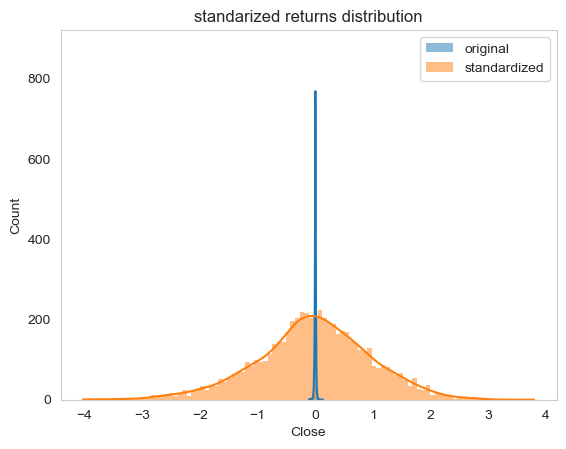

In [32]:
sns.histplot(
    ret,
    edgecolor = 'none',
    kde = True,
    bins = 100,
    label = 'original'
)
sns.histplot(
    std_ret,
    edgecolor = 'none',
    kde = True,
    bins = 100,
    label = 'standardized'
)
plt.legend()
plt.grid(False)
plt.title('standarized returns distribution')
plt.show()

#### Exercise 3

연습 1을 반복해서 이번에는 거래량 바에 삼중 배리어 방법을 적용한다. 최대 보유 기간은 하루 평균 바 수이며, 수평 배리어는 바 수익률의 두 표준 편차로 설정된다. 이때의 결과는 연습 1과 연습 2의 해답과 어떻게 비교되는가?

거래량 바를 생성할 수 없기 때문에 넘어가도록 한다

#### Exercise 4

연습 1을 반복한다. 이때 추세 검색 방법을 적용하고 최대 하루의 전망 기간을 갖는다. 이때의 결과는 연습 1,2,3의 해답과 어떻게 비교되는가?

In [73]:
from FinancialMachineLearning.labeling.trend_search import trend_labeling

trend = trend_labeling(data.index, data.Close, span = [1, 10, 1])

In [74]:
trend

,t1,tVal,bin
Date,,,
2000-09-18,2000-09-28,-3.705527,-1.0
2000-09-19,2000-09-29,-5.539916,-1.0
2000-09-20,2000-10-02,-4.025969,-1.0
2000-09-21,2000-10-03,-3.915349,-1.0
2000-09-22,2000-10-04,-4.206409,-1.0
...,...,...,...
2024-02-22,2024-03-05,2.212714,1.0
2024-02-23,2024-03-06,2.49158,1.0
2024-02-26,2024-03-07,3.861498,1.0


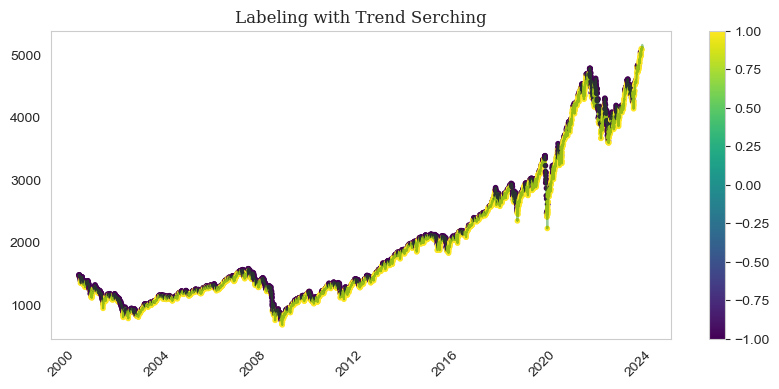

In [76]:
plt.figure(figsize = (10, 4))

plt.scatter(trend.index, data.Close.loc[trend.index].values, c = trend['bin'], cmap = 'viridis', marker = '.')
plt.plot(data.Close, color = 'green', alpha = 0.4)
plt.xticks(rotation=45)
plt.colorbar()
plt.grid(False)
plt.title('Labeling with Trend Serching', fontsize = 12, fontfamily = 'Serif')
plt.show()

In [78]:
trend['bin'].value_counts()

 1.0    3421
-1.0    2502
Name: bin, dtype: int64

#### Exercise 5

연습 3에서 생성된 레이블을 사용한다

**5.1**

레이블에 `RandomForestClassifier`를 적합화시킨다. 평균 수익률, 변동성, 왜도, 첨도 및 이동 평균의 여러 차이에 대한 추정치를 특성으로 사용하라.

In [135]:
from FinancialMachineLearning.features.microstructure import *

roll = roll_measure(data['Close'], window = 21)

In [136]:
from FinancialMachineLearning.features.volatility import *

yz = yang_zhang_volatility(data, window = 21)

In [137]:
from ta.volatility import BollingerBands
from ta.volume import money_flow_index, on_balance_volume
from ta.momentum import rsi
from ta.volume import volume_weighted_average_price
from ta.momentum import tsi
from ta.volume import ease_of_movement
from ta.volume import volume_price_trend

data['return'] = ret
data['rolling_mean'] = data['return'].rolling(window = 21).mean()
data['rolling_std'] = data['return'].rolling(window = 21).std()
data['rolling_skew'] = data['return'].rolling(window = 21).skew()
data['rolling_kurt'] = data['return'].rolling(window = 21).kurt()

indicator_bb = BollingerBands(close = data["Close"], window = 21, window_dev = 1)

data['bb_bbm'] = indicator_bb.bollinger_mavg()

data['mfi'] = money_flow_index(
    high = data.High, low = data.Low, 
    close = data.Close, volume = data.Volume, window = 21
)
data['obv'] = on_balance_volume(close = data.Close, volume = data.Volume)
data['rsi'] = rsi(close = data.Close, window = 21)
data['vwap'] = volume_weighted_average_price(
    high = data['High'], low = data['Low'],
    close = data['Close'], volume = data['Volume'], window = 21)
data['tsi'] = tsi(close = data['Close'], window_fast = 13, window_slow = 15)
data['eom'] = ease_of_movement(
    high = data['High'], low = data.Low, volume = data.Volume, window = 21
)
data['vpt'] = volume_price_trend(
    close = data.Close,
    volume = data.Volume
)

In [138]:
data['roll_spread'] = roll
data['yang_zhang'] = yz

In [139]:
data['bin'] = labels['bin']
data['bb_bbm'] = indicator_bb.bollinger_mavg().pct_change()

In [140]:
data.dropna(inplace = True)

In [141]:
data

,Open,High,Low,Close,Adj Close,Volume,return,rolling_mean,rolling_std,rolling_skew,...,mfi,obv,rsi,vwap,tsi,eom,vpt,roll_spread,yang_zhang,bin
Date,,,,,,,,,,,,,,,,,,,,,
2000-11-14,1359.00,1399.75,1358.50,1394.00,1394.00,101344,0.025612,0.000068,0.016170,0.390980,...,43.024819,-413891,45.872569,1398.596059,-6.928226,1.022662e+06,-7.004453e+03,16.829626,0.014414,-1.0
2000-11-15,1394.25,1404.50,1381.50,1397.50,1397.50,89420,0.002508,0.001304,0.015249,0.399617,...,47.853268,-324471,46.512208,1399.884756,-6.644288,3.568832e+05,-6.779940e+03,18.540657,0.014279,-1.0
2000-11-16,1396.75,1402.75,1376.50,1379.25,1379.25,180156,-0.013145,0.000889,0.015529,0.425355,...,46.161326,-504627,43.685757,1401.457237,-8.326862,-4.917613e+04,-9.132604e+03,16.847319,0.013379,-1.0
2000-11-17,1378.75,1393.50,1360.25,1370.50,1370.50,90660,-0.006364,-0.001074,0.013494,0.245012,...,41.713305,-595287,42.388990,1400.875579,-10.484638,-4.676125e+05,-9.707753e+03,19.751627,0.013412,-1.0
2000-11-20,1369.75,1373.50,1345.25,1347.75,1347.75,82907,-0.016739,-0.002184,0.013789,0.406742,...,37.928108,-678194,39.211405,1398.697349,-14.369167,-5.963007e+05,-1.108399e+04,17.740507,0.013310,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,5072.00,5114.50,5060.00,5103.75,5103.75,1790702,0.004467,0.002228,0.007404,0.254268,...,57.369727,273823907,65.083060,5019.559900,27.506923,3.043499e+04,-4.142956e+06,35.622124,0.006486,1.0
2024-03-01,5101.50,5149.25,5089.25,5146.00,5146.00,1597331,0.008244,0.002056,0.007210,0.255337,...,57.135470,275421238,67.659771,5031.157666,30.091186,1.202005e+05,-4.129732e+06,18.365000,0.006129,-1.0
2024-03-04,5142.00,5157.75,5132.00,5138.25,5138.25,1208040,-0.001507,0.001487,0.006983,0.448805,...,56.129777,274213198,66.711582,5039.857791,31.418592,5.462102e+04,-4.131552e+06,29.106455,0.005760,-1.0


In [164]:
from sklearn.model_selection import train_test_split

X = data.drop(['Open','High','Low','Close','Adj Close','Volume','vwap','bin','eom'], axis = 1)
y = data['bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [165]:
X

,return,rolling_mean,rolling_std,rolling_skew,rolling_kurt,bb_bbm,mfi,obv,rsi,tsi,vpt,roll_spread,yang_zhang
Date,,,,,,,,,,,,,
2000-11-14,0.025612,0.000068,0.016170,0.390980,-0.189190,0.000068,43.024819,-413891,45.872569,-6.928226,-7.004453e+03,16.829626,0.014414
2000-11-15,0.002508,0.001304,0.015249,0.399617,0.095390,0.001281,47.853268,-324471,46.512208,-6.644288,-6.779940e+03,18.540657,0.014279
2000-11-16,-0.013145,0.000889,0.015529,0.425355,-0.058412,0.000864,46.161326,-504627,43.685757,-8.326862,-9.132604e+03,16.847319,0.013379
2000-11-17,-0.006364,-0.001074,0.013494,0.245012,-0.157132,-0.001058,41.713305,-595287,42.388990,-10.484638,-9.707753e+03,19.751627,0.013412
2000-11-20,-0.016739,-0.002184,0.013789,0.406742,-0.221276,-0.002143,37.928108,-678194,39.211405,-14.369167,-1.108399e+04,17.740507,0.013310
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,0.004467,0.002228,0.007404,0.254268,1.007318,0.002214,57.369727,273823907,65.083060,27.506923,-4.142956e+06,35.622124,0.006486
2024-03-01,0.008244,0.002056,0.007210,0.255337,1.358628,0.002060,57.135470,275421238,67.659771,30.091186,-4.129732e+06,18.365000,0.006129
2024-03-04,-0.001507,0.001487,0.006983,0.448805,2.012351,0.001493,56.129777,274213198,66.711582,31.418592,-4.131552e+06,29.106455,0.005760


In [166]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 6,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = X_train, y = y_train)
oob_score = fit.oob_score_

In [167]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

y_prob = forest.predict_proba(X_test)[:, 1]
y_pred = forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.42955326460481097


In [168]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.34      0.19      0.25       355
         0.0       0.42      0.55      0.47       310
         1.0       0.47      0.53      0.50       499

    accuracy                           0.43      1164
   macro avg       0.41      0.42      0.41      1164
weighted avg       0.42      0.43      0.41      1164


**5.2**

레이블 생성에 사용된 것과 동일한 규칙을 거래 규칙으로 사용해 이들 예측을 백테스트하라

In [170]:
backtest = ret[-1164:] * y_pred

<Axes: title={'center': 'Backtest'}, xlabel='Date'>

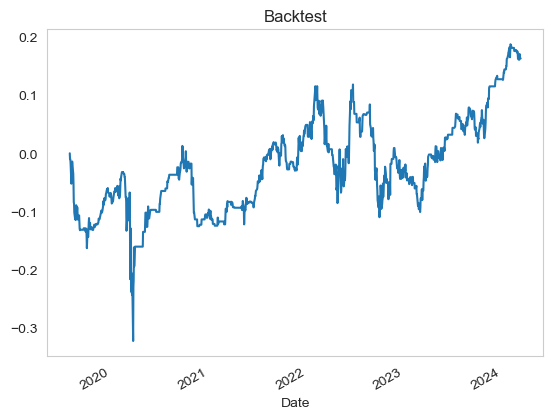

In [172]:
backtest.cumsum().plot(
    grid = False,
    title = 'Backtest'
)